In [1]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
import math

data_path = "./data/"

In [2]:
table = cv.imread(data_path + "src_balls.jpg")

### Original image

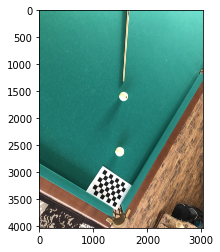

In [3]:
plt.imshow(cv.cvtColor(table, cv.COLOR_BGR2RGB))

In [4]:
ret, corners = cv.findChessboardCorners(cv.cvtColor(table, cv.COLOR_BGR2GRAY), (7, 5), None)
ret

True

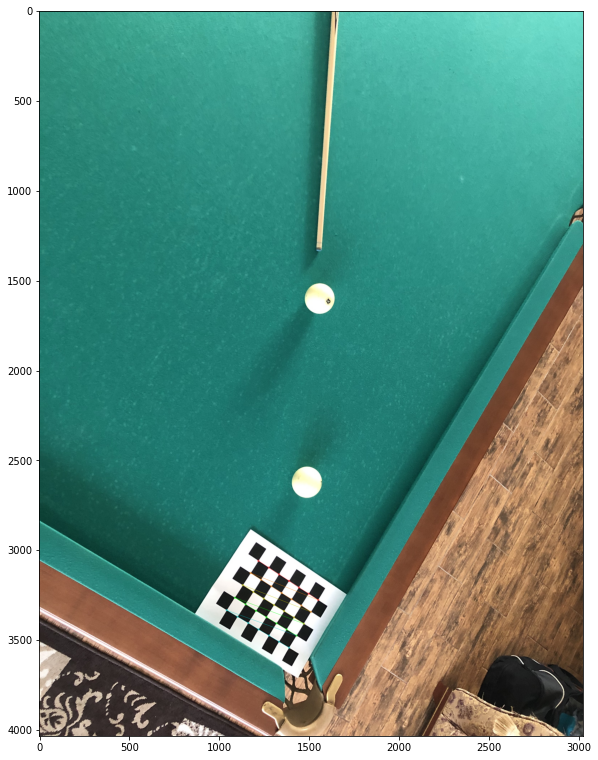

In [5]:
table_w_corners = table.copy()
cv.drawChessboardCorners(table_w_corners, (7,5), corners, ret)
scale_factor = 10
plt.figure(figsize = (scale_factor, scale_factor * table_w_corners.shape[0] / table_w_corners.shape[1]))
plt.imshow(cv.cvtColor(table_w_corners, cv.COLOR_BGR2RGB))

### Undistortion

In [6]:
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)
fine_corners = cv.cornerSubPix(cv.cvtColor(table, cv.COLOR_BGR2GRAY), corners, (11,11), (-1,-1), criteria)

In [7]:
objpoints = np.zeros((1, 7*5,3), np.float32)
objpoints[0, :,:2] = np.mgrid[0:7,0:5].T.reshape(-1,2)
objpoints.shape

(1, 35, 3)

In [8]:
imgpoints = fine_corners
imgpoints.shape

(35, 1, 2)

In [9]:
ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, [imgpoints], cv.cvtColor(table, cv.COLOR_BGR2GRAY).shape[::-1], None, None)

In [10]:
h, w = table.shape[:2]
newcameramtx, roi = cv.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))

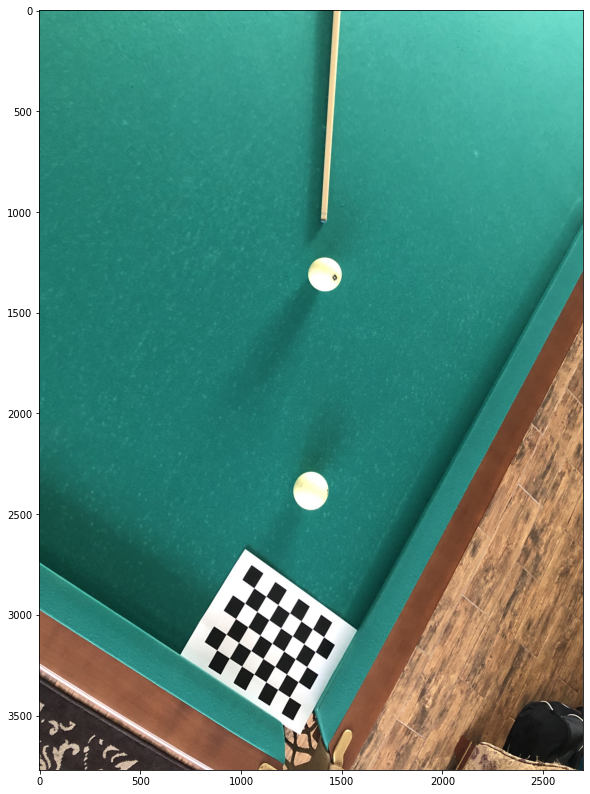

In [11]:
undist_table = cv.undistort(table, mtx, dist, None, newcameramtx)
# crop the image
x, y, w, h = roi
undist_table = undist_table[y:y+h, x:x+w]
scale_factor = 10
plt.figure(figsize = (scale_factor, scale_factor * undist_table.shape[0] / undist_table.shape[1]))
plt.imshow(cv.cvtColor(undist_table, cv.COLOR_BGR2RGB))

### Warping the image

In [12]:
ret, undist_corners = cv.findChessboardCorners(cv.cvtColor(undist_table, cv.COLOR_BGR2GRAY), (7, 5), None)
ret

True

In [13]:
fine_undist_corners = cv.cornerSubPix(cv.cvtColor(undist_table, cv.COLOR_BGR2GRAY), undist_corners, (11,11), (-1,-1), criteria)
input_pts = np.array([fine_undist_corners[0][0], fine_undist_corners[6][0], fine_undist_corners[-7][0], fine_undist_corners[-1][0]])
input_pts

array([[1067.9034 , 2868.1648 ],
       [1413.8188 , 3111.2324 ],
       [ 883.40314, 3176.0247 ],
       [1244.2449 , 3409.7393 ]], dtype=float32)

In [14]:
final_img_width, final_img_height = 4000, 4000
board_right_offset = 500
chess_cell_width = 100
output_pts = np.float32([[final_img_width - chess_cell_width*7, final_img_height - chess_cell_width*5],
                         [final_img_width, final_img_height - chess_cell_width*5],
                         [final_img_width - chess_cell_width*7, final_img_height],
                         [final_img_width, final_img_height]])
output_pts -= board_right_offset
output_pts

array([[2800., 3000.],
       [3500., 3000.],
       [2800., 3500.],
       [3500., 3500.]], dtype=float32)

In [15]:
perspective_mat = cv.getPerspectiveTransform(input_pts, output_pts)
perspective_mat

array([[ 8.80283007e-01,  6.83798475e-01, -4.79513355e+02],
       [-1.02607983e+00,  9.85115639e-01,  8.65055863e+02],
       [-1.05900786e-04, -7.66446992e-06,  1.00000000e+00]])

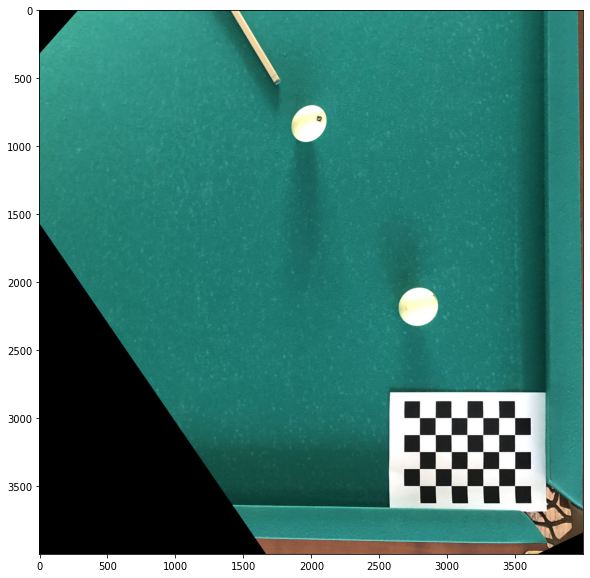

In [16]:
warped_table = cv.warpPerspective(undist_table, perspective_mat,(final_img_width, final_img_height),flags=cv.INTER_LINEAR)
scale_factor = 10
plt.figure(figsize = (scale_factor, scale_factor * warped_table.shape[0] / warped_table.shape[1]))
plt.imshow(cv.cvtColor(warped_table, cv.COLOR_BGR2RGB))

### Drawing chessboard corners

In [17]:
ret, warped_corners = cv.findChessboardCorners(cv.cvtColor(warped_table, cv.COLOR_BGR2GRAY), (7, 5), None)
ret

True

In [18]:
fine_warp_corners = cv.cornerSubPix(cv.cvtColor(warped_table, cv.COLOR_BGR2GRAY), warped_corners, (11,11), (-1,-1), criteria)

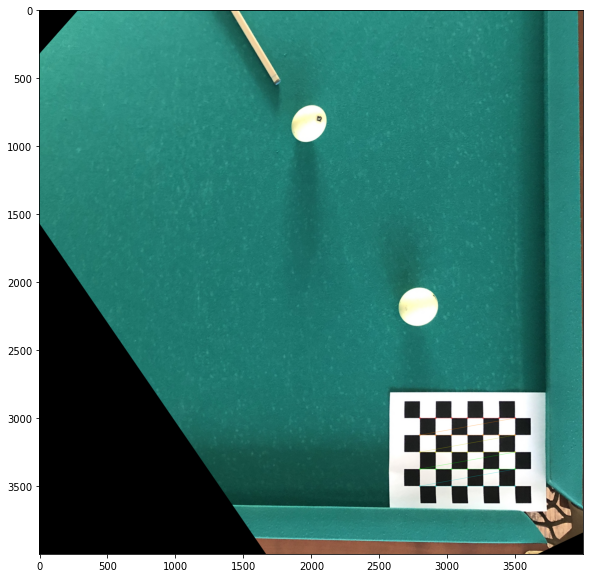

In [19]:
cv.drawChessboardCorners(warped_table, (7,5), fine_warp_corners, ret)
scale_factor = 10
plt.figure(figsize = (scale_factor, scale_factor * warped_table.shape[0] / warped_table.shape[1]))
plt.imshow(cv.cvtColor(warped_table, cv.COLOR_BGR2RGB))

### Finding the stick

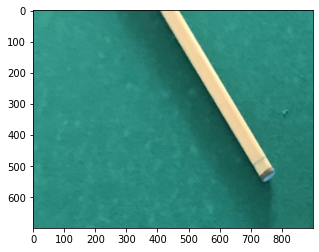

In [20]:
stick_on_the_table = warped_table[:700, 1000:1900, :]
plt.imshow(cv.cvtColor(stick_on_the_table, cv.COLOR_BGR2RGB))

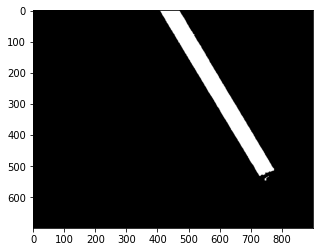

In [21]:
_, binary_stick = cv.threshold(stick_on_the_table[:, :, 2],100,255,cv.THRESH_BINARY)
plt.imshow(binary_stick, cmap="gray")

In [22]:
contours, _ = cv.findContours(binary_stick, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
print(f"Found {len(contours)} figures")
cpy = binary_stick.copy()
for c in contours:
    print(cv.minAreaRect(c))
(stick_cx, stick_cy), (stick_width, stick_height), angle = cv.minAreaRect(contours[1])
stick_angle = angle / 180 * math.pi
print(f"Stick's angle is {stick_angle} rad")

Found 2 figures
((750.7500610351562, 539.7500610351562), (6.363960266113281, 18.384777069091797), 45.0)
((592.50634765625, 255.9899444580078), (630.00244140625, 56.06960678100586), 58.93169403076172)
Stick's angle is 1.0285520946146804 rad


### Finding circle centers

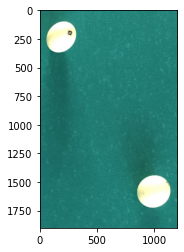

In [23]:
x_ball_offset, y_ball_offset = 600, 1800
balls = warped_table[x_ball_offset:2500, y_ball_offset:3000, :]
plt.imshow(cv.cvtColor(balls, cv.COLOR_BGR2RGB))

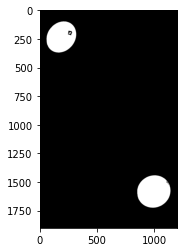

In [24]:
_, binary_balls = cv.threshold(balls[:, :, 2],150,255,cv.THRESH_BINARY)
plt.imshow(binary_balls, cmap="gray")

Found 2 figures
Found a circle with center: [990, 1582] and diameter 285.5
Found a circle with center: [186, 235] and diameter 265.0


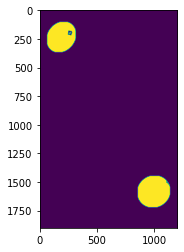

In [25]:
contours, _ = cv.findContours(binary_balls, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
print(f"Found {len(contours)} figures")
centers = []
radiuses = []
for i, c in enumerate(contours):
    x, y, w, h = cv.boundingRect(c)
    cv.rectangle(binary_balls, (x, y), (x+w, y+h), (0, 255, 0), 8)
    cx = x + w // 2
    cy = y + h // 2
    diameter = (w + h) / 2
    centers.append([cx, cy])
    radiuses.append(diameter / 2)
    print(f"Found a circle with center: [{cx}, {cy}] and diameter {diameter}")
centers = np.array(centers) + [y_ball_offset, x_ball_offset]
plt.imshow(binary_balls)

### Overall drawing

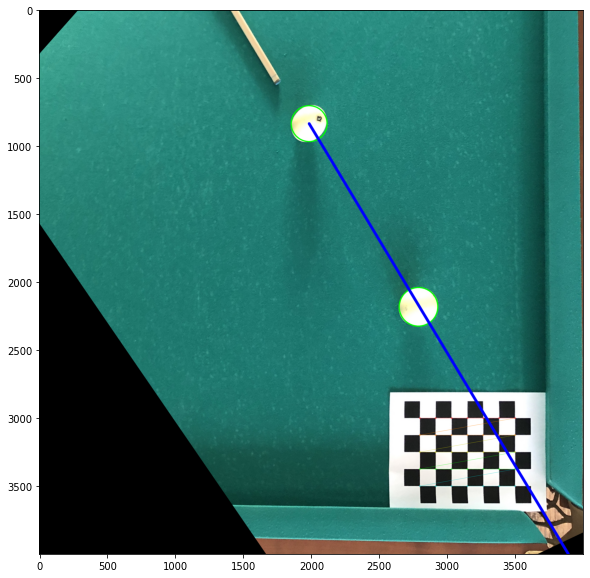

In [26]:
# BALL RADIUS IS NOT 56!
warped_table_cpy = warped_table.copy()
for i, point in enumerate(centers):
    cv.circle(warped_table_cpy, (point[0], point[1]), int(radiuses[i]), (0, 255, 0), 8)

first_ball_x_endpoint = centers[1][0] + (warped_table_cpy.shape[0] - centers[1][1]) / math.tan(stick_angle)
cv.line(warped_table_cpy, (centers[1][0], centers[1][1]), (int(first_ball_x_endpoint), warped_table_cpy.shape[0]), (255, 0, 0), 20)

scale_factor = 10
plt.figure(figsize = (scale_factor, scale_factor * warped_table_cpy.shape[0] / warped_table_cpy.shape[1]))
plt.imshow(cv.cvtColor(warped_table_cpy, cv.COLOR_BGR2RGB))

### Calculating the collision point

In [27]:
balls_dist = ((centers[0][0] - centers[1][0])**2 + (centers[0][1] - centers[1][1])**2)**0.5
after_collision_dist = radiuses[0] + radiuses[1]
ball1_angle = math.fabs(math.pi/2 - stick_angle)
ball2_angle = math.fabs(math.atan((centers[0][0] - centers[1][0]) / (centers[0][1] - centers[1][1])))
delta_angle = math.pi - math.asin(balls_dist * math.sin(ball1_angle - ball2_angle) / after_collision_dist)
collision_angle = math.pi * 3 / 2 - ball1_angle - delta_angle

x_collision = int(centers[0][0] - after_collision_dist * math.cos(collision_angle))
y_collision = int(centers[0][1] - after_collision_dist * math.sin(collision_angle))

### The second ball will roll in the red line direction

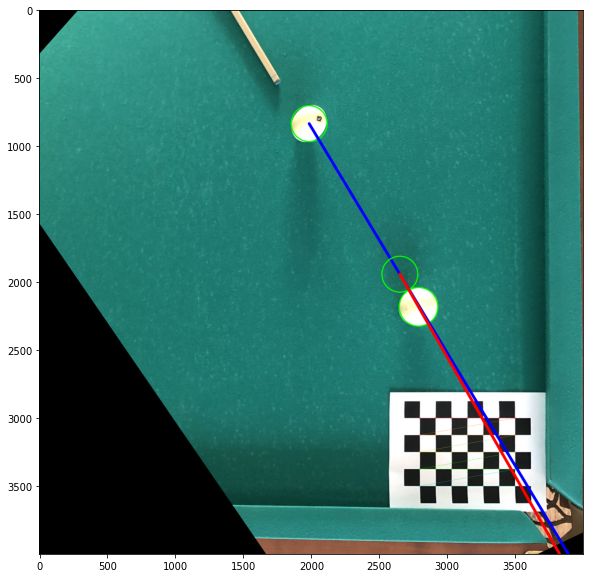

In [28]:
warped_table_cpy = warped_table.copy()
for i, point in enumerate(centers):
    cv.circle(warped_table_cpy, (point[0], point[1]), int(radiuses[i]), (0, 255, 0), 8)

first_ball_x_endpoint = centers[1][0] + (warped_table_cpy.shape[0] - centers[1][1]) / math.tan(stick_angle)
cv.line(warped_table_cpy, (centers[1][0], centers[1][1]), (int(first_ball_x_endpoint), warped_table_cpy.shape[0]), (255, 0, 0), 20)

line_scale = 10
cv.circle(warped_table_cpy, (x_collision, y_collision), int(radiuses[1]), (0, 255, 0), 8)
cv.line(warped_table_cpy, (x_collision, y_collision), (x_collision + (centers[0][0] - x_collision) * line_scale, y_collision + (centers[0][1] - y_collision) * line_scale), (0, 0, 255), 20)

scale_factor = 10
plt.figure(figsize = (scale_factor, scale_factor * warped_table_cpy.shape[0] / warped_table_cpy.shape[1]))
plt.imshow(cv.cvtColor(warped_table_cpy, cv.COLOR_BGR2RGB))